## 1. Download dei dati ##

In [2]:
# Download dataset
#!wget https://www.zemris.fer.hr/projects/LicensePlates/english/baza_slika.zip
# Unzip file zip
#!unzip -o -j baza_slika.zip "*.jpg" -d dataset

## 2. Preparazione dei dati ##

In [1]:
# Divisione dataset 
import os

import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io

from PIL import Image

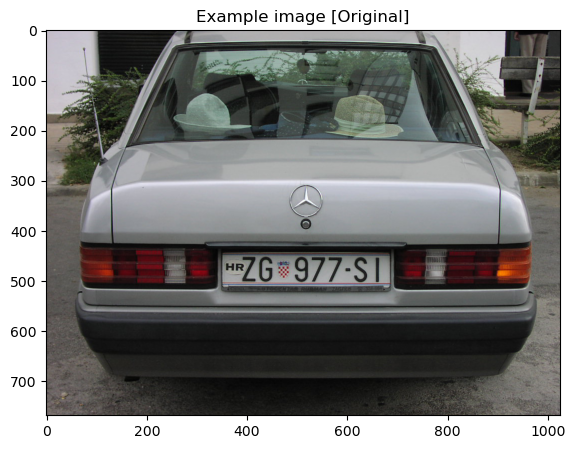

In [2]:
# Percorso alla cartella che contiene le immagini
datasetPath = "dataset"

# Lista per salvare le immagini caricate
imgList = []

# Scorrimento di tutti i file nella cartella
for fileName in os.listdir(datasetPath):
    if fileName.lower().endswith(".jpg"):
        filePath = os.path.join(datasetPath, fileName)
        img = Image.open(filePath)
        imgList.append(img)

# Mostriamo un'immagine
index = np.random.randint(0,len(imgList))
plt.figure(figsize=(15,5))
plt.imshow(imgList[index])
plt.title('Example image [Original]')
plt.show()

In [3]:
# Importiamo le librerie per il training
import torch
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# Divisione dell'intero dataset in training set, validation set e test set (Circa 80%, 10% e 10%)
trainSet, valSet, testSet = random_split(imgList, [0.8, 0.1, 0.1])

# Creazione dei DataLoader per i set
batchSize = 60
numWorkers = 4

trainDataload = DataLoader(trainSet, batch_size=batchSize, shuffle=True, num_workers=numWorkers)
valDataload = DataLoader(valSet, batch_size=batchSize, num_workers=numWorkers)
testDataload = DataLoader(testSet, batch_size=batchSize, num_workers=numWorkers)

print("Effettuata suddivisione:")
print(f"- Training-set: {len(trainSet)} campioni.")
print(f"- Validation-set: {len(valSet)} campioni.")
print(f"- Test-set: {len(testSet)} campioni.")

Effettuata suddivisione:
- Training-set: 403 campioni.
- Validation-set: 50 campioni.
- Test-set: 50 campioni.


In [5]:
from skimage.transform import rescale, resize
from skimage.util import view_as_windows

In [ ]:
# Prova Davide 21/5/25
# Downscale+upscale degli stessi blocchi
'''
import numpy as np
from skimage.util import view_as_windows
from skimage.transform import resize, rescale
from skimage import img_as_float
import matplotlib.pyplot as plt
from PIL import Image

def extract_patches(img, patch_size=(96, 96), stride=24):

    step = (stride, stride, 1)
    window_shape = (patch_size[0], patch_size[1], img.shape[2])
    windows = view_as_windows(img, window_shape, step)  # shape: (n_h, n_w, 1, h, w, c)
    patches = windows.squeeze(2)  # shape: (n_h, n_w, h, w, c)
    n_h, n_w, h, w, c = patches.shape
    patches = patches.reshape(-1, h, w, c)  # shape: (n_patches, 96, 96, 3)
    return patches

def degrade_patches(patches, scale=4):

    degraded = []
    for patch in patches:
        h, w, c = patch.shape
        # Downscale
        small = rescale(patch, 1/scale, order=1, channel_axis=-1)
        # Upscale back
        upsampled = rescale(small, scale, order=1, channel_axis=-1)
        degraded.append(upsampled)
    return np.stack(degraded, axis=0)

def prepare_input_target_from_image(img, patch_size=(96, 96), stride=24, scale=4):

    img = img_as_float(img)  # normalizza in [0, 1]
    patches_hr = extract_patches(img, patch_size, stride)  # HR patches
    patches_interp = degrade_patches(patches_hr, scale)    # interpolated
    return patches_interp.astype(np.float32)


def reconstruct_from_patches(patches, image_shape, patch_size=(96, 96), stride=24):

    h, w, c = image_shape
    ph, pw = patch_size

    reconstructed = np.zeros((h, w, c), dtype=np.float32)
    weight = np.zeros((h, w, c), dtype=np.float32)

    idx = 0
    for i in range(0, h - ph + 1, stride):
        for j in range(0, w - pw + 1, stride):
            reconstructed[i:i+ph, j:j+pw] += patches[idx]
            weight[i:i+ph, j:j+pw] += 1
            idx += 1

    # Evitiamo divisione per zero
    weight[weight == 0] = 1
    return (reconstructed / weight).clip(0, 1)

'''
    

Text(0.5, 1.0, 'Ricostruita dai patch interpolati')

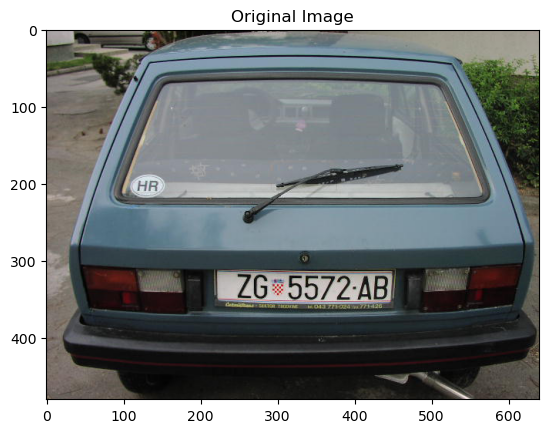

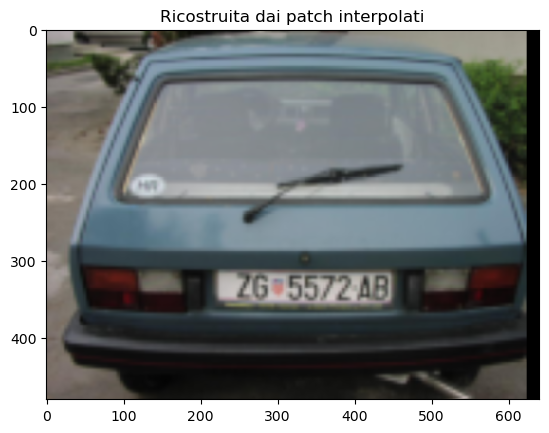

In [ ]:
'''
from PIL import Image
import numpy as np
from numpy import random


# Se hai una lista di immagini PIL
index = random.randint(0,200)
# Estrai patch da un'immagine
img_np = np.array(imgList[index])
height, width, channels = img_np.shape
x_patches = prepare_input_target_from_image(img_np)

# Ricostruisci immagine dai patch interpolati (low-res + upsampled)
reconstructed_interp = reconstruct_from_patches(x_patches, img_np.shape)
reconstructed_interp = resize(reconstructed_interp, (height, width, channels))


# Visualizza
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img_np)
plt.title("Original Image")

plt.figure()
plt.imshow(reconstructed_interp)
plt.title("Ricostruita dai patch interpolati")
'''

In [67]:
# Prova 22/5/25
# Downscale blocchi + upscale immagine

import numpy as np
from skimage.util import view_as_windows
from skimage.transform import resize, rescale
from skimage import img_as_float
import matplotlib.pyplot as plt
from PIL import Image


def extract_patches(img, patchSize=(96,96), stride=24):
    step = (stride, stride, 1)
    windowShape = (patchSize[0], patchSize[1], img.shape[2])
    windows = view_as_windows(img, windowShape, step)
    patches = windows.squeeze(2)
    n_h, n_w, h, w, c = patches.shape
    patches = patches.reshape(-1,h,w,c)
    return patches

def degrade_patches(patches, scale=2):
    degraded = []
    for patch in patches:
        h,w,c = patch.shape
        small = rescale(patch, 1/scale, order=1, channel_axis=-1)
        degraded.append(small)
    return np.stack(degraded, axis=0)

def prepare_input_target_from_image(img, patch_size=(96,96), stride=24, scale=2):
    img = img_as_float(img)
    patchesHR = extract_patches(img, patch_size, stride)
    patchesLR = degrade_patches(patchesHR, scale)
    return patchesLR.astype(np.float32)

def reconstruct_from_patches(patches, imageShape, patchSize=(96,96), stride=12):
    h,w,c = (int(imageShape[0]/2), int(imageShape[1]/2), int(imageShape[2]))
    ph, pw = (int(patchSize[0]/2), int(patchSize[1]/2))
    

    lowRes = np.zeros((h,w,c), dtype=np.float32)
    weight = np.zeros((h,w,c), dtype=np.float32)

    index = 0
    for i in range(0,h-ph+1,stride):
        for j in range(0,w-pw+1,stride):
            lowRes[i:i+ph, j:j+pw] += patches[index]
            weight[i:i+ph, j:j+pw] += 1
            index += 1
    
    # Si evita la divisione per 0
    weight[weight == 0] = 1
    return (lowRes / weight).clip(0, 1)




Text(0.5, 1.0, 'upScaled')

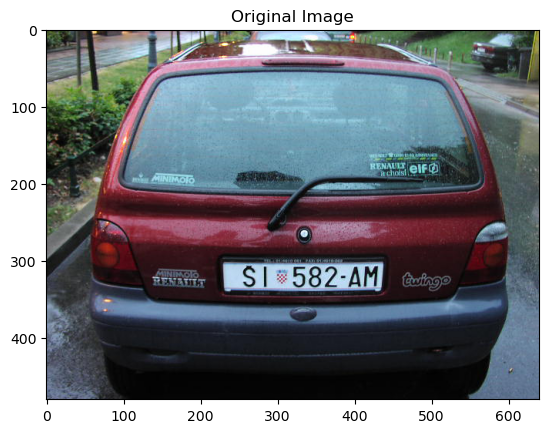

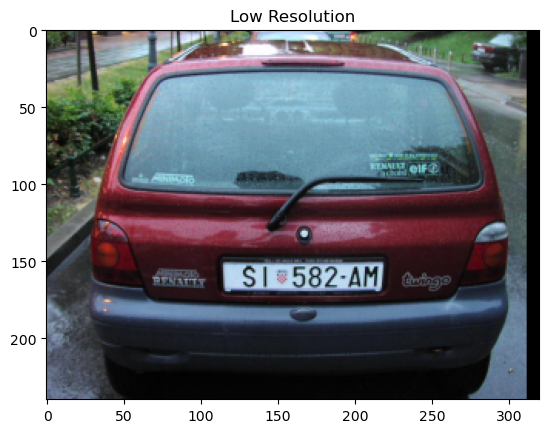

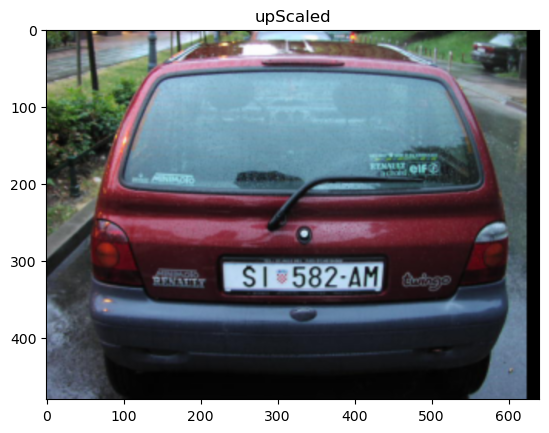

In [68]:
from numpy import random

index = random.randint(0,200)
# Estrai patch da un'immagine
img_np = np.array(imgList[index])
height, width, channels = img_np.shape
x_patches = prepare_input_target_from_image(img_np)

lowRes = reconstruct_from_patches(x_patches, img_np.shape)
upScaled = rescale(lowRes, 2, order=1, channel_axis=-1)


# Visualizza
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img_np)
plt.title("Original Image")

plt.figure()
plt.imshow(lowRes)
plt.title("Low Resolution")

plt.figure()
plt.imshow(upScaled)
plt.title("upScaled")